In [1]:
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import minimize

## Our favorite bi-objective problem

In [2]:
def F1(x):
    return x[0]

def wrap_F2(a,b):
    def F2(x):
        return 1 - x[0] - a * np.sin(b * np.pi * x[0]) + x[1]**2 
    return F2

## theoretical solution from the weighted scalarization method
def solution(a,b):
    def frontier(w1,w2):
        return 1/(b*np.pi)* np.arccos((w1/w2 -1)/(a*b*np.pi))
    return frontier

### Convex to non-convex case

In [29]:
convex=False
 
if convex:
    ####
    ## convex case 
    #### 
    a=0.2
    b=1
else:
    ##
    #non-convex case
    ##
    a=0.1
    b=3


## define the parameter-dependent objectives and weight domain
opt_x1=solution(a,b)
F2=wrap_F2(a,b)

inf=1-a*b*np.pi
sup=1+a*b*np.pi
print(f'to satisfy arccosine argument between [-1,1],{inf}  < w1/w2 < {sup}')

## initialize a list of normalized weights
ws_list = []
for w0 in np.linspace(0.01,0.99, 10001):
    ws_list.append([w0, 1. - w0])


check_list=[ws[0]/ws[1] for ws in ws_list]
mask=[(val>=inf) and (val<=sup) for val in check_list]

ws_list_allowed=[]
for i, ws in enumerate(ws_list):
    if mask[i]:
        ws_list_allowed.append(ws)

to satisfy arccosine argument between [-1,1],0.057522203923061954  < w1/w2 < 1.942477796076938


Find optimal solutions and compute optimal points in the ojective space

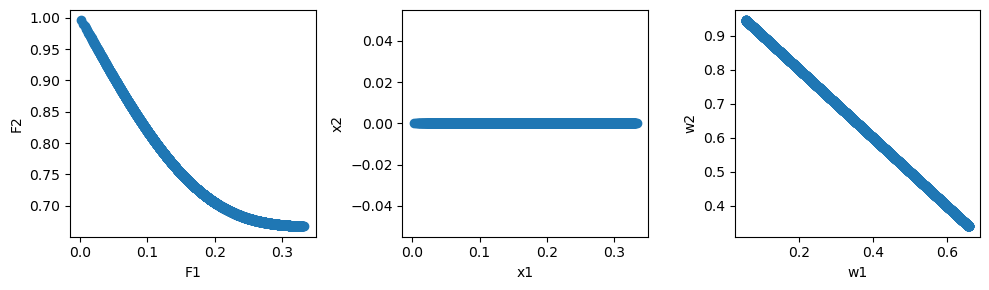

In [30]:
## define values of theoretical optimal decision variable value x1
x_optimal=[[opt_x1(w1,w2),0] for w1,w2 in ws_list_allowed]


##filter values according to x domain [0,2]x[0,2]
mask=(np.array(x_optimal)[:,0]<2) & (np.array(x_optimal)[:,0]>=0)
x_optimal=np.array(x_optimal)[mask]

## compute objectives values
F1_optimal=[F1(x) for x in x_optimal.tolist()]
F2_optimal=[F2(x) for x in x_optimal.tolist()]

## compute valid weights
w1=np.array(ws_list_allowed)[:,0][mask]
w2=np.array(ws_list_allowed)[:,1][mask]


## plot pareto front, optimal set, and weigths used 
fig, (ax1,ax2,ax3) = plt.subplots(ncols=3,figsize=(10,3))

ax1.scatter(F1_optimal,F2_optimal)
ax1.set_xlabel('F1')
ax1.set_ylabel('F2')

ax2.scatter(x_optimal[:,0],x_optimal[:,1])
ax2.set_xlabel('x1')
ax2.set_ylabel('x2')

ax3.scatter(w1,w2)
ax3.set_xlabel('w1')
ax3.set_ylabel('w2')


plt.tight_layout()

plt.show()

<p>The non-convex case looks pretty convex to me... we need to get suspicious. 
<p>Let us use brute force to get an approximation of the first Pareto front.

## Defining Pareto Ranks

In [31]:
## dominance relation from previous notebook
def dominates(f1,f2):
    return np.all(f1<=f2) and np.any(f1<f2)

## Algorithm to find all non-dominated points in a set
## input: list of lists or np.array of dimension [P,O] 
## P = number of points, O = number of objectives
## output: indices of the non-dominated points
def ParetoFront(list_fs):
    list_fs=np.array(list_fs)
    pareto_front = list()
    point_dominates={}
    point_is_dominated_by={}

    for idi, _ in enumerate(list_fs):
        point_dominates[idi] = list()
        point_is_dominated_by[idi] = list()
    
    for id1, obj1 in enumerate(list_fs): ## upper triangular matrix
        for index2, obj2 in enumerate(list_fs[id1 + 1:]):  # Avoid redundant comparisons
            id2 = index2 + id1 + 1
            if dominates(obj1,obj2):
                point_dominates[id1].append(id2)
                point_is_dominated_by[id2].append(id1)
            elif dominates(obj2,obj1):
                point_dominates[id2].append(id1)
                point_is_dominated_by[id1].append(id2)

        if not point_is_dominated_by[id1]:
            pareto_front.append(id1)
            
    return pareto_front 




Brute-force sampling and PO point selection

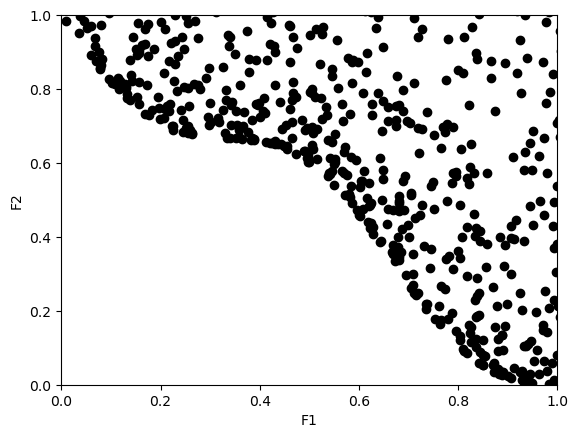

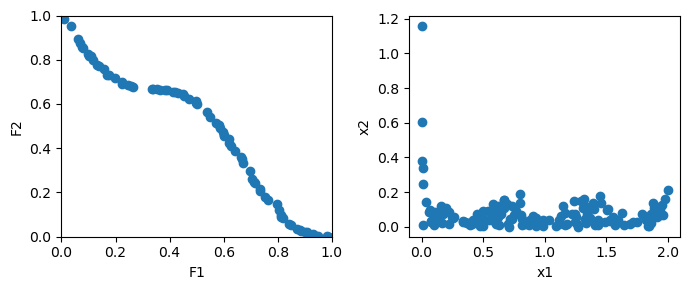

In [33]:
convex=False
 
if convex:
    ####
    ## convex case 
    #### 
    a=0.2
    b=1
else:
    ##
    #non-convex case
    ##
    a=0.1
    b=3

F2=wrap_F2(a,b)

## Inside the domain [0,2]x[0,2], sample a huge number of point (not too huge, scales quadratically)
xm = np.random.rand(3000, 2)
xm = 2*xm 


plt.scatter([F1(xi) for xi in xm],[F2(xi) for xi in xm],color='k')
plt.xlabel('F1')
plt.xlim([0,1])
plt.ylabel('F2')
plt.ylim([0,1])
plt.show()


## Identify PO points indices
PO_indices=ParetoFront([[F1(xi),F2(xi)] for xi in xm])

## Plot PO points and decision variables associated to PO points
fig, (ax1,ax2) = plt.subplots(ncols=2,figsize=(7,3))

ax1.scatter([F1(xm[i]) for i in PO_indices],[F2(xm[i]) for i in PO_indices])
ax1.set_xlabel('F1')
ax1.set_ylabel('F2')
ax1.set_xlim([0,1])
ax1.set_ylim([0,1])


x_top=np.concatenate([xm[[i]] for i in PO_indices])

ax2.scatter(x_top[:,0],x_top[:,1])
ax2.set_xlabel('x1')
ax2.set_ylabel('x2')

plt.tight_layout()

plt.show()




# Scalarization methods

In [52]:
## function useful to mask out solutions outside the allowed domain 
def mask_within_domain(x,extremes):
    bottom,top=extremes
    mask=(x>np.array(bottom)).all(1) & (x<=np.array(top)).all(1)
    return mask

## linear weighting from previous notebook
def generate_scalar_linear_obj(fs: list, ws: list):
    def scalar_obj(x):
        return np.sum([w * f(x) for w, f in zip(ws, fs)])
    return scalar_obj

## power weighting 
def generate_scalar_power_obj(fs: list, ws: list, p:int):
    def scalar_obj(x):
        return np.sum([w * (f(x))**p for w, f in zip(ws, fs)])
    return scalar_obj

## metric weighting
def generate_scalar_weighted_metric_obj(fs: list, ws: list, power:int, utopian_point:list):
    def scalar_obj(x):
        scalar_list=[(w * abs(f(x)-u))**power for w, f, u in zip(ws, fs, utopian_point)]
        return np.sum(scalar_list)**(1/power)
    return scalar_obj

##Chebyshev weighting
def generate_scalar_Chebyshev_obj(fs: list, ws: list, utopian_point:list):
    def scalar_obj(x):
        scalar_list=[(w * abs(f(x)-u)) for w, f, u in zip(ws, fs, utopian_point)]
        return max(scalar_list)
    return scalar_obj

##exponential weighting
def generate_exponential_obj(fs: list, ws: list, p:int):
    def scalar_obj(x):
        return np.sum([(np.exp( w * p ) - 1) * np.exp( p * f(x) ) for w, f in zip(ws, fs)])
    return scalar_obj

##product weighting
def generate_product_obj(fs: list, ws: list):
    def scalar_obj(x):
        return np.prod([abs(f(x))**w for w, f in zip(ws, fs)])
    return scalar_obj

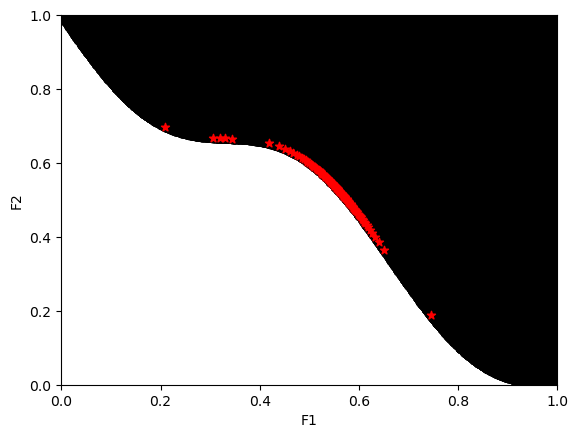

In [59]:
## AVAILABLE SCALARIZATION METHODS:
## 'scalar','power','weighted_metric','chebyshev','weighted_exp','weighted_product'
method='power'
power=10


## utopian point from DM (me)
utopian_point=[0.,0.]


# domain [x1, x2]  0 < x1 < 1, -2 < x2 < 2
# random sampling inside the domain for plot purposes
x = np.random.rand(100000, 2)
x[:, 1] = x[:, 1] * 4 - 2

## define values to be used in 
## - masking points inside the domain (extremes) 
## - defining domain in the scipy optimizer (bnds)
extremes=[[0,-2],[1,2]]
bnds = ((0., 1.), (-2., 2.))

## initialize a list of normalized weights
ws_list = []
for w0 in np.linspace(0, 1, 101):
    ws_list.append([w0, 1. - w0])

## initialize a list of optimal weights and x values to survive filtering  
optimal_ws = []
optimal_x = []
for ws in ws_list:
    if method=='scalar':
        scalarized_obj = generate_scalar_linear_obj([F1,F2],ws)
    elif method=='power':
        scalarized_obj = generate_scalar_power_obj([F1,F2],ws,power)
    elif method=='weighted_metric':
        scalarized_obj = generate_scalar_weighted_metric_obj([F1,F2],ws,power,utopian_point)
    elif method=='chebyshev':
        scalarized_obj = generate_scalar_Chebyshev_obj([F1,F2],ws,utopian_point)
    elif method=='weighted_exp':
        scalarized_obj = generate_exponential_obj([F1,F2],ws,power)
    elif method=='weighted_product':
        scalarized_obj = generate_product_obj([F1,F2],ws)
    
    
    res = minimize(scalarized_obj, x0=[0.5, 0.], bounds=bnds)
    
    if res.success:
        optimal_x.append(res.x.tolist())
        optimal_ws.append(ws)
        

optimal_x = np.array(optimal_x)
optimal_ws = np.array(optimal_ws)



## mask points outside the domain
mask=mask_within_domain(optimal_x,extremes)
optimal_x=optimal_x[mask]


## plot allowed objective space area and optimal points
plt.scatter([F1(xi) for xi in x],[F2(xi) for xi in x],color='k')
plt.scatter([F1(xi) for xi in optimal_x],[F2(xi) for xi in optimal_x],marker='*',color='red')
plt.xlabel('F1')
plt.ylabel('F2')
plt.xlim([0,1])
plt.ylim([0,1])
plt.show()

## Focus on power method

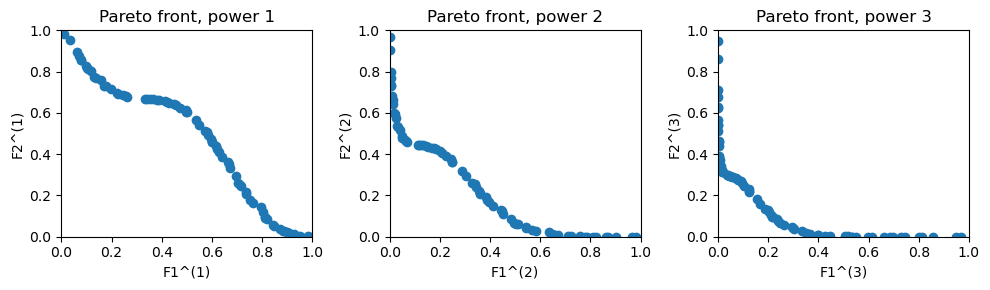

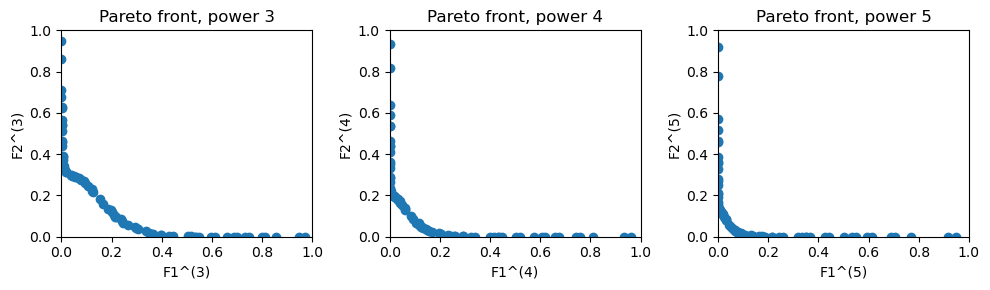

In [60]:
## keep on using xm previously generate
## plot pareto front, optimal set, and weigths used 
fig, axs = plt.subplots(ncols=3,figsize=(10,3))

for i in range(3):
    p=i+1
    axs[i].scatter([F1(xm[i])**(p) for i in PO_indices],[F2(xm[i])**p for i in PO_indices])
    axs[i].set_xlabel(f'F1^({p})')
    axs[i].set_ylabel(f'F2^({p})')
    axs[i].set_xlim([0,1])
    axs[i].set_ylim([0,1])
    axs[i].set_title(f'Pareto front, power {p}')

plt.tight_layout()
plt.show()


fig, axs = plt.subplots(ncols=3,figsize=(10,3))
for i in range(3):
    p=i+3
    axs[i].scatter([F1(xm[i])**(p) for i in PO_indices],[F2(xm[i])**p for i in PO_indices])
    axs[i].set_xlabel(f'F1^({p})')
    axs[i].set_ylabel(f'F2^({p})')
    axs[i].set_xlim([0,1])
    axs[i].set_ylim([0,1])
    axs[i].set_title(f'Pareto front, power {p}')

plt.tight_layout()

plt.show()





## Focus on metric methods

#### Changing p fixing the weights

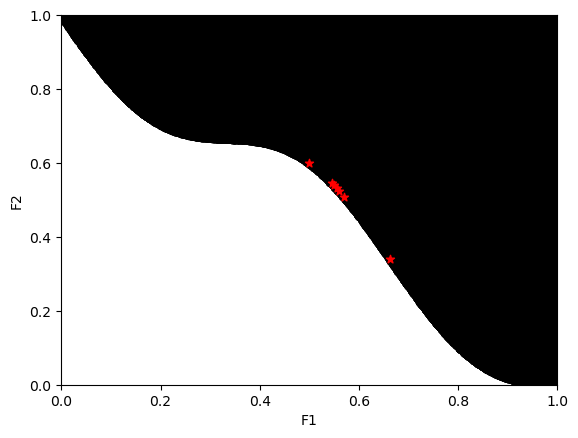

In [61]:
ws=[0.5,0.5]
utopian_point=[0.,0.]
p_list=[1,2,5,7,10,20,200]

optimal_p = []
optimal_x = []
for power in p_list:
    scalarized_obj = generate_scalar_weighted_metric_obj([F1,F2],ws,power,utopian_point)
    
    res = minimize(scalarized_obj, x0=[0.5, 0.], bounds=bnds)
    
    if res.success:
        optimal_x.append(res.x.tolist())
        optimal_p.append(power)
        

optimal_x = np.array(optimal_x)
optimal_p = np.array(optimal_ws)


mask=mask_within_domain(optimal_x,extremes)
optimal_x=optimal_x[mask]


plt.scatter([F1(xi) for xi in x],[F2(xi) for xi in x],color='k')
plt.scatter([F1(xi) for xi in optimal_x],[F2(xi) for xi in optimal_x],marker='*',color='red')
plt.xlabel('F1')
plt.ylabel('F2')
plt.xlim([0,1])
plt.ylim([0,1])
plt.show()

#### Plot single solution: discover the meaning of weights and powers 

In [62]:
## function to be used in generating the isocurves
def generate_isocurves_weighted_metric_obj(ws: list, power:int, utopian_point:list):
    def scalar_obj(fs):
        scalar_list=[(w * abs(fi-u))**power for w, fi, u in zip(ws, fs, utopian_point)]
        return np.sum(scalar_list)**(1/power)
    return scalar_obj

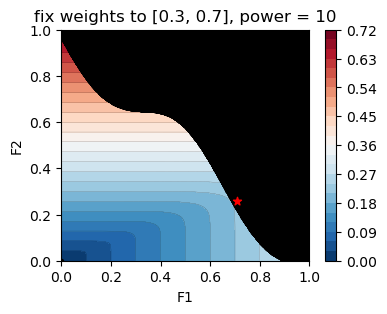

In [65]:
ws=[0.3,0.7]
utopian_point=[0.,0.]
power=10



scalarized_obj = generate_scalar_weighted_metric_obj([F1,F2],ws,power,utopian_point)
res = minimize(scalarized_obj, x0=[0.5, 0.], bounds=bnds)
if res.success:
    optimal_x=res.x
        


f_random=np.random.rand(20000,2)
f_isocur=generate_isocurves_weighted_metric_obj(ws, power, utopian_point)
f_power_list=[f_isocur(fi) for fi in f_random]



fig, ax = plt.subplots(nrows=1,figsize=(4,3))

ax.tricontour(f_random[:,0], f_random[:,1], f_power_list, levels=24, linewidths=0.1, colors='k')
cntr2 = ax.tricontourf(f_random[:,0], f_random[:,1], f_power_list, levels=24 , cmap="RdBu_r")
fig.colorbar(cntr2, ax=ax)

ax.plot(utopian_point[0], utopian_point[1], 'ko', ms=3)

ax.scatter([F1(xi) for xi in x],[F2(xi) for xi in x],color='k')
ax.scatter([F1(optimal_x)],[F2(optimal_x)],marker='*',color='red')


ax.set_xlabel('F1')
ax.set_ylabel('F2')
ax.set(xlim=(0, 1), ylim=(0, 1))
ax.set_title(f'fix weights to {ws}, power = {power}' )
plt.subplots_adjust(hspace=0.5)
plt.show()

## Epsilon-constraint method

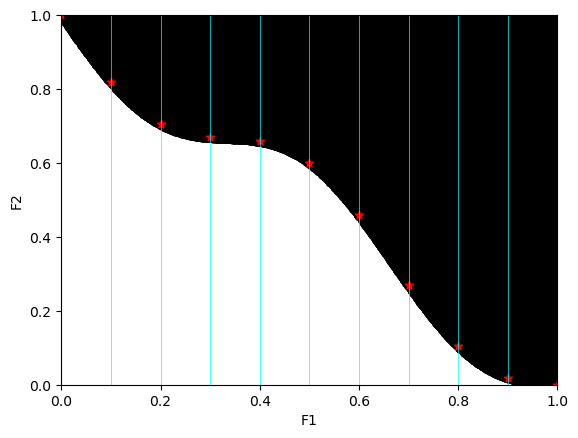

In [66]:
## EXAMPLE 1
# Equality constraint means that the constraint function result is to be zero 
# whereas inequality means that it is to be non-negative
# fi(x)<=eps  --> eps-fi(x)>=0


## define grid of epsilon values
epsilon_list=np.linspace(0,1,11).tolist()
options={'maxiter':1000}
## define x domain for the scipy optimizer (bnds)
bnds = ((0., 1.), (-2., 2.))



optimal_x = []
opt_eps=[]
## initialize a list of optimal weights and x values to survive filtering  
for eps in epsilon_list:
    cons = ({'type': 'ineq', 'fun': lambda x:  eps-F1(x)})
    res = minimize(F2, x0=[0.5, 0.], method='SLSQP', bounds=bnds, constraints=cons)
    
    if res.success:
        optimal_x.append(res.x.tolist())
        opt_eps.append(eps)


## Plot domain, solution, grid lines     
plt.scatter([F1(xi) for xi in x],[F2(xi) for xi in x],color='k')
plt.scatter([F1(xi) for xi in optimal_x],[F2(xi) for xi in optimal_x],marker='*',color='red')
for eps in epsilon_list:
    plt.vlines(eps,0,1,color='cyan', linewidth=0.5)
plt.xlabel('F1')
plt.ylabel('F2')
plt.xlim([0,1])
plt.ylim([0,1])
plt.show()

## NBI method

Define the new problem

minimize $(f_1(x_1,x_2),f_2(x_1,x_2))=(x_1,x_2)$

satifying the constraint $g(x_1,x_2)=x_2-5 \exp{- x_1}-2\exp{-0.5 (x_1-2.1)^2}\geq0$

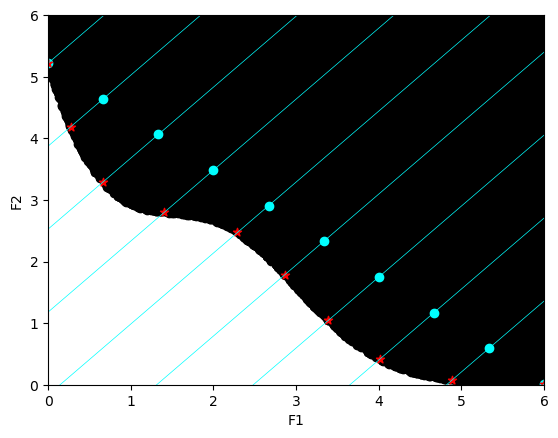

In [67]:

bnds = ((0., 6.), (0., 6.))
options={'maxiter':1000}
x = 6.*np.random.rand(100000, 2)
cons0=[{'type':'ineq', 'fun': lambda x: x[1]-5*np.exp(-x[0])-2*np.exp(-0.5*(x[0]-2.1)**2)}]

def F1(x):
    return x[0]
def F3(x):
    return x[1]

res = minimize(F1, (0, 0), method='SLSQP', bounds=bnds, constraints=cons0)
optimal_x_F1 = res.x
res = minimize(F3, (0, 0), method='SLSQP', bounds=bnds, constraints=cons0)
optimal_x_F3 = res.x

A=np.array([F1(optimal_x_F1),F3(optimal_x_F1)])
B=np.array([F1(optimal_x_F3),F3(optimal_x_F3)])


ws_list = []
for w0 in np.linspace(0, 1, 10):
    ws_list.append([w0, 1. - w0])
    
p_list=[ws[0]*A+ws[1]*B for ws in ws_list]

optimal_x = []
for p in p_list:
    cons=cons0+[{'type':'eq', 'fun': lambda x: np.matmul(B-A,np.array([F1(x),F3(x)])-p)}]
    res = minimize(F1, (0, 0), method='SLSQP', bounds=bnds, constraints=cons)
    optimal_x.append(res.x)
    

list_fs=[np.array([F1(xi),F3(xi)]) for xi in optimal_x]
first_pareto_front_indices=ParetoFront(list_fs)
first_pareto_front=[optimal_x[i] for i in first_pareto_front_indices]

m=(B[1]-A[1])/(B[0]-A[0])

indices=np.where(np.array([cons0[0]['fun'](xi) for xi in x])>=0)[0]
plt.scatter([F1(xi) for xi in x[indices]],[F3(xi) for xi in x[indices]],color='k')
plt.scatter(np.array(p_list)[:,0],np.array(p_list)[:,1],color='cyan')
for p in p_list:
    plt.plot(np.linspace(0,12,10).tolist(),[p[1]-1/m*(xi-p[0]) for xi in np.linspace(0,12,10)],
             color='cyan',
            linewidth=0.5)

plt.scatter([F1(xi) for xi in optimal_x],[F3(xi) for xi in optimal_x],marker='*',color='red')
plt.xlabel('F1')
plt.ylabel('F2')
plt.xlim([0,6])
plt.ylim([0,6])
plt.show()